# Classifier Training

Imports & Setup

In [12]:
import os
import numpy as np
import cv2
import tensorflow as tf
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from tqdm import tqdm
import matplotlib.pyplot as plt
from warnings import filterwarnings

filterwarnings('ignore')


2025-11-25 19:09:02.011503: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-25 19:09:02.042815: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-25 19:09:02.864723: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [17]:
!ls /home/slim/Projects/NeuroScan-AI/data/Classification-Tumor/Training


glioma_tumor  meningioma_tumor	no_tumor  pituitary_tumor


Dataset Loader (4 classes)

In [18]:
X = []
y = []

image_size = 150

train_path = "/home/slim/Projects/NeuroScan-AI/data/Classification-Tumor/Training"
test_path  = "/home/slim/Projects/NeuroScan-AI/data/Classification-Tumor/Testing"

def load_images(path):
    data = []
    labels_list = []
    for label in labels:
        folder = os.path.join(path, label)
        print("Loading:", folder)

        for img_name in tqdm(os.listdir(folder), desc=label):

            # Only accept valid image extensions
            if not img_name.lower().endswith((".jpg", ".jpeg", ".png")):
                # Skip Zone.Identifier and weird files
                # print("Skipping:", img_name)
                continue

            img_path = os.path.join(folder, img_name)
            img = cv2.imread(img_path)

            if img is None:
                print("❌ Invalid or corrupt image:", img_path)
                continue

            img = cv2.resize(img, (image_size, image_size))
            data.append(img)
            labels_list.append(label)

    return data, labels_list


trainX, trainY = load_images(train_path)
testX,  testY  = load_images(test_path)

X = np.array(trainX + testX)
y = np.array(trainY + testY)

X, y = shuffle(X, y, random_state=101)

print("Dataset shape:", X.shape)


Loading: /home/slim/Projects/NeuroScan-AI/data/Classification-Tumor/Training/glioma_tumor


glioma_tumor: 100%|██████████| 1652/1652 [00:00<00:00, 1655.11it/s]


Loading: /home/slim/Projects/NeuroScan-AI/data/Classification-Tumor/Training/no_tumor


no_tumor: 100%|██████████| 790/790 [00:00<00:00, 2169.97it/s]


Loading: /home/slim/Projects/NeuroScan-AI/data/Classification-Tumor/Training/meningioma_tumor


meningioma_tumor: 100%|██████████| 1644/1644 [00:00<00:00, 1772.25it/s]


Loading: /home/slim/Projects/NeuroScan-AI/data/Classification-Tumor/Training/pituitary_tumor


pituitary_tumor: 100%|██████████| 1654/1654 [00:01<00:00, 1519.97it/s]


Loading: /home/slim/Projects/NeuroScan-AI/data/Classification-Tumor/Testing/glioma_tumor


glioma_tumor: 100%|██████████| 200/200 [00:00<00:00, 1958.91it/s]


Loading: /home/slim/Projects/NeuroScan-AI/data/Classification-Tumor/Testing/no_tumor


no_tumor: 100%|██████████| 210/210 [00:00<00:00, 4564.79it/s]


Loading: /home/slim/Projects/NeuroScan-AI/data/Classification-Tumor/Testing/meningioma_tumor


meningioma_tumor: 100%|██████████| 230/230 [00:00<00:00, 2356.68it/s]


Loading: /home/slim/Projects/NeuroScan-AI/data/Classification-Tumor/Testing/pituitary_tumor


pituitary_tumor: 100%|██████████| 148/148 [00:00<00:00, 745.16it/s]


Dataset shape: (3264, 150, 150, 3)


Train/Test Split + One Hot Encode

In [19]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.1, random_state=101
)

# Convert labels to integers
y_train = np.array([labels.index(i) for i in y_train])
y_test  = np.array([labels.index(i) for i in y_test])

# One Hot Encode
y_train = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_test  = tf.keras.utils.to_categorical(y_test, num_classes=4)


EfficientNet-B0 Model

In [20]:
effnet = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(image_size, image_size, 3)
)

x = effnet.output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.5)(x)
output = tf.keras.layers.Dense(4, activation='softmax')(x)

model = tf.keras.Model(inputs=effnet.input, outputs=output)

model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


W0000 00:00:1764094369.473324    2466 gpu_device.cc:2342] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 10s 1us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 150, 150,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 150, 150,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 150, 150,  │          7 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_1         │ (None, 150, 150,  │          0 │ normalization[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 151, 151,  │          0 │ rescaling_1[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 75, 75,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 75, 75,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 75, 75,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 75, 75,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 75, 75,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 75, 75,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 75, 75,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 75, 75,    │        512 │ block1a_se_excit

 Total params: 4,054,695 (15.47 MB)

 Trainable params: 4,012,672 (15.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

Callbacks (Save Best Model + LR Scheduler + EarlyStopping)

In [21]:
checkpoint = ModelCheckpoint(
    "efficientnet_best.h5",
    monitor="val_accuracy",
    save_best_only=True,
    verbose=1,
    mode="max"
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.3,
    patience=2,
    min_delta=0.001,
    verbose=1
)

early_stop = EarlyStopping(
    monitor='val_accuracy',
    patience=5,
    restore_best_weights=True,
    verbose=1
)


Training

In [22]:
history = model.fit(
    X_train, y_train,
    validation_split=0.1,
    epochs=20,
    batch_size=32,
    callbacks=[checkpoint, reduce_lr, early_stop],
    verbose=1
)


Epoch 1/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.7502 - loss: 0.6514
Epoch 1: val_accuracy improved from None to 0.88095, saving model to efficientnet_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 73s 676ms/step - accuracy: 0.8331 - loss: 0.4712 - val_accuracy: 0.8810 - val_loss: 0.4700 - learning_rate: 0.0010
Epoch 2/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 639ms/step - accuracy: 0.9422 - loss: 0.1853
Epoch 2: val_accuracy did not improve from 0.88095
83/83 ━━━━━━━━━━━━━━━━━━━━ 55s 658ms/step - accuracy: 0.9448 - loss: 0.1751 - val_accuracy: 0.8810 - val_loss: 0.3846 - learning_rate: 0.0010
Epoch 3/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 634ms/step - accuracy: 0.9615 - loss: 0.1159
Epoch 3: val_accuracy improved from 0.88095 to 0.93197, saving model to efficientnet_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 55s 657ms/step - accuracy: 0.9527 - loss: 0.1431 - val_accuracy: 0.9320 - val_loss: 0.3129 - learning_rate: 0.0010
Epoch 4/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.9501 - loss: 0.1455
Epoch 4: val_accuracy did not improve from 0.93197
83/83 ━━━━━━━━━━━━━━━━━━━━ 54s 654ms/step - accuracy: 0.9516 - loss: 0.1333 - val_accuracy: 0.9320 - val_loss: 0.2933 - learning_rate: 0.0010
Epoch 5/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9770 - loss: 0.0798
Epoch 5: val_accuracy did not improve from 0.93197

Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
83/83 ━━━━━━━━━━━━━━━━━━━━ 55s 658ms/step - accuracy: 0.9754 - loss: 0.0810 - val_accuracy: 0.9014 - val_loss: 0.3938 - learning_rate: 0.0010
Epoch 6/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 637ms/step - accuracy: 0.9839 - loss: 0.0458
Epoch 6: val_accuracy improved from 0.93197 to 0.96259, saving model to efficientnet_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 55s 661ms/step - accuracy: 0.9886 - loss: 0.0389 - val_accuracy: 0.9626 - val_loss: 0.1720 - learning_rate: 3.0000e-04
Epoch 7/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 635ms/step - accuracy: 0.9914 - loss: 0.0224
Epoch 7: val_accuracy did not improve from 0.96259
83/83 ━━━━━━━━━━━━━━━━━━━━ 54s 655ms/step - accuracy: 0.9951 - loss: 0.0157 - val_accuracy: 0.9626 - val_loss: 0.1266 - learning_rate: 3.0000e-04
Epoch 8/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.9981 - loss: 0.0087
Epoch 8: val_accuracy improved from 0.96259 to 0.96939, saving model to efficientnet_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 55s 664ms/step - accuracy: 0.9974 - loss: 0.0101 - val_accuracy: 0.9694 - val_loss: 0.1249 - learning_rate: 3.0000e-04
Epoch 9/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.9972 - loss: 0.0096
Epoch 9: val_accuracy did not improve from 0.96939
83/83 ━━━━━━━━━━━━━━━━━━━━ 54s 656ms/step - accuracy: 0.9977 - loss: 0.0088 - val_accuracy: 0.9660 - val_loss: 0.1469 - learning_rate: 3.0000e-04
Epoch 10/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 636ms/step - accuracy: 0.9968 - loss: 0.0087
Epoch 10: val_accuracy did not improve from 0.96939

Epoch 10: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
83/83 ━━━━━━━━━━━━━━━━━━━━ 54s 656ms/step - accuracy: 0.9970 - loss: 0.0082 - val_accuracy: 0.9694 - val_loss: 0.1243 - learning_rate: 3.0000e-04
Epoch 11/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 648ms/step - accuracy: 0.9993 - loss: 0.0044
Epoch 11: val_accuracy improved from 0.96939 to 0.97619, saving model to efficientnet_best.h5


83/83 ━━━━━━━━━━━━━━━━━━━━ 56s 672ms/step - accuracy: 0.9981 - loss: 0.0059 - val_accuracy: 0.9762 - val_loss: 0.1194 - learning_rate: 9.0000e-05
Epoch 12/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9997 - loss: 0.0038
Epoch 12: val_accuracy did not improve from 0.97619
83/83 ━━━━━━━━━━━━━━━━━━━━ 55s 657ms/step - accuracy: 0.9992 - loss: 0.0036 - val_accuracy: 0.9728 - val_loss: 0.1196 - learning_rate: 9.0000e-05
Epoch 13/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 638ms/step - accuracy: 0.9960 - loss: 0.0134
Epoch 13: val_accuracy did not improve from 0.97619

Epoch 13: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
83/83 ━━━━━━━━━━━━━━━━━━━━ 55s 658ms/step - accuracy: 0.9977 - loss: 0.0085 - val_accuracy: 0.9762 - val_loss: 0.1222 - learning_rate: 9.0000e-05
Epoch 14/20
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 640ms/step - accuracy: 0.9986 - loss: 0.0055
Epoch 14: val_accuracy did not improve from 0.97619
83/83 ━━━━━━━━━━━━━━━━━━━━ 55s 659ms/step - accuracy: 0.9974 - loss

Load Best Model

In [23]:
model = tf.keras.models.load_model("efficientnet_best.h5")


Predictions + Evaluation

11/11 ━━━━━━━━━━━━━━━━━━━━ 4s 257ms/step
                  precision    recall  f1-score   support

    glioma_tumor       0.98      0.91      0.94        93
        no_tumor       1.00      0.98      0.99        51
meningioma_tumor       0.92      0.99      0.95        96
 pituitary_tumor       1.00      1.00      1.00        87

        accuracy                           0.97       327
       macro avg       0.97      0.97      0.97       327
    weighted avg       0.97      0.97      0.97       327



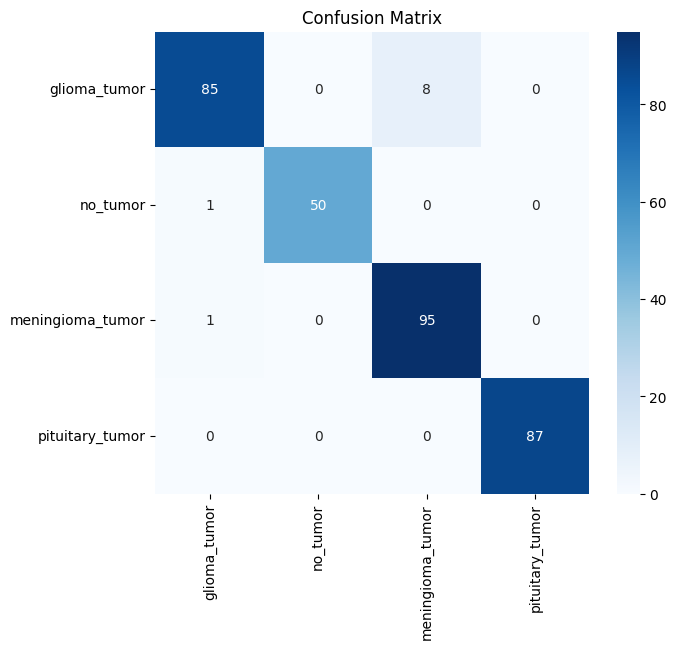

In [24]:
pred = model.predict(X_test)
pred = np.argmax(pred, axis=1)

y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, pred, target_names=labels))

cm = confusion_matrix(y_true, pred)
plt.figure(figsize=(7,6))
plt.title("Confusion Matrix")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
plt.show()
